In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Generate stock options
class StockOptions:
    def __init__(self, init_price, strike, rf_rate, mean, var, ex_time, steps, iters, payoff = 'Asian'):
        self.s_0 = float(init_price)           # Price of underlying today
        self.K = float(strike)                 # Strike price
        self.r = float(rf_rate)                # Risk free rate
        self.exp = float(mean)                 # Expected return
        self.sig = float(var)                  # Expected volume
        self.T = float(ex_time)                # Expired days
        self.m = steps                         # Number of steps every iteration
        self.dt = float(self.T) / self.m       # Length of Steps
        self.N = iters                         # Number of sumulation paths
        self.S = zeros((self.N, self.m))       # Matrix containing all the simulated pathsx
        self.Z = zeros((self.N, self.m))       # Array containing all the normal distribution random variables
        self.payoffFuncs = {                   # Payoff options
            'Asian' : self.PayoffAsian
        }
        self.PayFun = self.payoffFuncs[payoff] # Selected payoff function
        self.PricesByMC()                      # Generate price paths by MC

    # Calculate S(t + 1) given S(t)
    def AssetPath(self, s_old, z):
        return s_old * exp((self.exp - 0.5 * self.sig) * self.dt
                            +  sqrt(self.sig * self.dt) * z)

    # Payoff (Asian)
    def PayoffAsian(self, S):
        avg = 0.0
        for i in xrange(self.m):
            avg += S[i]
        avg /= self.m
        return max(0.0, avg - self.K)
    
    # Expected Probability Density
    def EPD(self, s):
        return exp(-(log(s) - log(self.s_0)) ** 2 / (2.0 * self.sig))

    # Transition Probability Density Ratio
    def TPDR(self, s1, s2, rv1, rv2):
        pSum = (self.exp - 0.5 * self.sig) * self.dt
        pFactor = sqrt(self.sig * self.dt)
        delta_p1 = pSum + pFactor * rv1
        delta_p2 = pSum + pFactor * rv2
        return exp(-abs(log(s2) - log(s1) - delta_p1) / self.dt) /\
               exp(-abs(log(s1) - log(s2) - delta_p2) / self.dt)
        
    # Simulate the paths via MC
    def PricesByMC(self):
        H = 0.0
        # First path
        self.S[0][0] = self.s_0
        for j in xrange(1, self.m):
            self.Z[0][j] = random.normal(0, 1)
            self.S[0][j] = self.AssetPath(self.S[0][j-1], self.Z[0][j])
        for i in xrange(1, self.N):
            self.S[i][0] = self.s_0
            for j in xrange(1, self.m):
                z = random.normal(0, 1)
                self.Z[i][j] = z
                s_old = self.S[i-1][j]
                s_new = self.AssetPath(s_old, z)
#                ratio = self.EPD(s_new) / self.EPD(s_old)  * self.TPDR(s_new, s_old, 
#                                                                       self.Z[i][j], self.Z[i-1][j])
                ratio = self.EPD(s_new) / self.EPD(s_old)
                self.S[i][j] = s_new if random.rand() < ratio else s_old
                        
    # Compute Payoff
    def Payoff(self):
        avg = 0.0
        for i in xrange(self.N):
            avg += self.PayFun(self.S[i])
        avg /= self.N
        return avg / ((1.0 + self.r) ** (self.T / 360.0))
    
    # Plot paths
    def PlotPaths(self, sample = 1.0):
        plt.figure()
        time = [i * self.dt for i in xrange(self.m)]
        for i in xrange(self.m):
            if rand() <= sample:
                plt.plot(time, self.S[i])
    
    # Plot endpoints
    def HistEndpoints(self, bins = 50):
        endpoints = [self.S[i][-1] for i in xrange(self.N)]
        plt.figure()
        hist(endpoints, bins)

In [3]:
# Create asian options and simulate using MC
asian = StockOptions(init_price = 207.330002,
                     strike = 150.0,
                     rf_rate = 0.03,
                     mean = -0.000419601957843,
                     var = 0.0214357830351,
                     ex_time = 20.0,
                     steps = 365,
                     iters = 1000,
                     payoff = 'Asian')

Final payoff: 54.6488866563


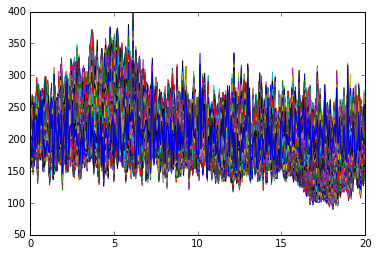

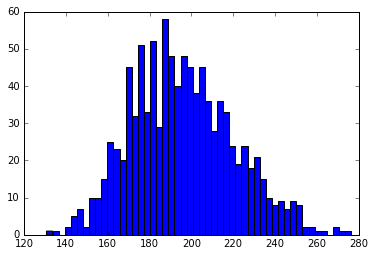

In [4]:
# Plot all paths
asian.PlotPaths(sample = 1.0)
# Final prices
asian.HistEndpoints()
# Final payoff
print 'Final payoff: ' + str(asian.Payoff())